# OpenRemote: Energy Transition

## Intro

### Technologies used

## Imports

In [10]:
!pip install fastai
!pip install pyarrow

In [11]:
import os
import warnings
import datetime as dt
import json
import requests
import sys

import pandas as pd
import matplotlib.pyplot as plt
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from pytz import timezone
import numpy as np

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import export_graphviz
from sklearn import metrics

from fastai.imports import *
from fastai.tabular import *

from IPython.display import display, Image

In [12]:
import IPython

In [13]:
PATH = ".\\data\\"

In [14]:
!dir {'.'} #Windows Only Command

 Volume in drive C is Windows
 Volume Serial Number is 984A-EC2B

 Directory of C:\Users\simon\OneDrive - PXL\School\2TINQ\_Research Project\OpenRemote-Energy-Challenge\machine-learning

16/06/2021  12:36    <DIR>          .
16/06/2021  12:36    <DIR>          ..
23/03/2021  20:33             1.948 .gitignore
16/05/2021  19:51    <DIR>          .ipynb_checkpoints
28/03/2021  20:21    <DIR>          .vscode
06/04/2021  11:01               551 api-integration.py
02/05/2021  19:20    <DIR>          data
25/03/2021  12:45            96.784 data-visualisation.ipynb
25/03/2021  12:23             2.511 data-visualisation.py
28/03/2021  20:31            38.747 estimated_actuals.json
16/06/2021  12:36            28.864 machine-learning.ipynb
03/05/2021  20:38             1.471 machine-learning.py
16/05/2021  19:52    <DIR>          media
18/05/2021  10:25             2.430 README.md
16/05/2021  19:52    <DIR>          tmp

 Directory of C:\Users\simon\OneDrive - PXL\School\2TINQ\_Research Proje

## API Calls for datasets

In [20]:
API_URL = "https://api.openuv.io/api/v1/forecast"
API_KEY = input("API-key: ")
PREDICTION_PERIOD = 30 #Minutes
TIME_ZONE = timezone("Europe/Amsterdam")

API-key: bc9f0600d36c131f75def897cd96083a


In [21]:
# OpenRemote Building Location
LAT = '51.444594'
LNG = '5.457884'
DT = '2021-02-05 01:08:59.353'

In [22]:
#http = urllib3.PoolManager(cert_reqs='CERT_REQUIRED', ca_certs=certifi.where())
def get_uv_values(lat, lng, dt):
    try:
        resp = requests.get(API_URL,
            headers={"content-type":"application/json", "x-access-token": API_KEY}, 
            params={'lat': lat, 'lng': lng})
        print("Request sent to API.")
        
        if resp.status_code != 200:     # This means something went wrong
            raise requests.ConnectionError('GET openuv forecast {}'.format(resp.status_code))
        print("Response received.")
        
    except Exception as e:
        print("Could not connect to the API")
        print(str(e))
    
    rows = []
    columns = ['uv', 'uv_time', 'azimuth', 'altitude']

    for data in resp.json():
        for row in resp.json()[data]:
            new_row = [row['uv'], row['uv_time']]
            for key in row['sun_position']:
                new_row.append(row['sun_position'][key])
            rows.append(new_row)

    uv_predictions = pd.DataFrame(rows, columns=columns)
    uv_predictions['uv_time'] = pd.to_datetime(uv_predictions['uv_time'])
    uv_predictions['uv_time'] = pd.DatetimeIndex(pd.to_datetime(uv_predictions.uv_time, utc=True)).tz_convert(TIME_ZONE)
    return uv_predictions

In [23]:
uv_predictions = get_uv_values(LAT, LNG, DT)
uv_predictions

Request sent to API.
Response received.


,uv,uv_time,azimuth,altitude
0,0.0000,2021-06-16 05:22:01.515000+02:00,-2.280492,-0.012722
1,0.1066,2021-06-16 06:22:01.515000+02:00,-2.080430,0.120932
2,0.4652,2021-06-16 07:22:01.515000+02:00,-1.888301,0.270156
3,1.2114,2021-06-16 08:22:01.515000+02:00,-1.696255,0.429096
4,2.4131,2021-06-16 09:22:01.515000+02:00,-1.493330,0.591948
5,4.2157,2021-06-16 10:22:01.515000+02:00,-1.263380,0.751864
6,5.8826,2021-06-16 11:22:01.515000+02:00,-0.981599,0.898837
7,7.3557,2021-06-16 12:22:01.515000+02:00,-0.614417,1.015984
8,7.9566,2021-06-16 13:22:01.515000+02:00,-0.146395,1.077128
9,7.7531,2021-06-16 14:22:01.515000+02:00,0.355419,1.059935


In [24]:
solar_data = pd.read_csv(f"{PATH}SolarData.csv", parse_dates=["timestamp"])

## Handy functions

In [25]:
def display_all(df):
    with pd.option_context("display.max_rows", 10000, "display.max_columns", 10000): 
        display(df)

In [26]:
def train_cats(df):
    for n,c in df.items():
        if is_string_dtype(c): df[n] = c.astype('category').cat.as_ordered()

In [27]:
def proc_df(df, y_fld=None, skip_flds=None, ignore_flds=None, do_scale=False, na_dict=None,
            preproc_fn=None, max_n_cat=None, subset=None, mapper=None):
    if not ignore_flds: ignore_flds=[]
    if not skip_flds: skip_flds=[]
    if subset: df = get_sample(df,subset)
    else: df = df.copy()
    ignored_flds = df.loc[:, ignore_flds]
    df.drop(ignore_flds, axis=1, inplace=True)
    if preproc_fn: preproc_fn(df)
    if y_fld is None: y = None
    else:
        if not is_numeric_dtype(df[y_fld]): df[y_fld] = pd.Categorical(df[y_fld]).codes
        y = df[y_fld].values
        skip_flds += [y_fld]
    df.drop(skip_flds, axis=1, inplace=True)

    if na_dict is None: na_dict = {}
    else: na_dict = na_dict.copy()
    na_dict_initial = na_dict.copy()
    for n,c in df.items(): na_dict = fix_missing(df, c, n, na_dict)
    if len(na_dict_initial.keys()) > 0:
        df.drop([a + '_na' for a in list(set(na_dict.keys()) - set(na_dict_initial.keys()))], axis=1, inplace=True)
    if do_scale: mapper = scale_vars(df, mapper)
    for n,c in df.items(): numericalize(df, c, n, max_n_cat)
    df = pd.get_dummies(df, dummy_na=True)
    df = pd.concat([ignored_flds, df], axis=1)
    res = [df, y, na_dict]
    if do_scale: res = res + [mapper]
    return res

In [28]:
def fix_missing(df, col, name, na_dict):
    if is_numeric_dtype(col):
        if pd.isnull(col).sum() or (name in na_dict):
            df[name+'_na'] = pd.isnull(col)
            filler = na_dict[name] if name in na_dict else col.median()
            df[name] = col.fillna(filler)
            na_dict[name] = filler
    return na_dict

In [29]:
def numericalize(df, col, name, max_n_cat):
    if not is_numeric_dtype(col) and ( max_n_cat is None or len(col.cat.categories)>max_n_cat):
        df[name] = pd.Categorical(col).codes+1

In [30]:
def split_vals(a,n): return a[:n], a[n:]

In [31]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

In [32]:
def print_score(m):
    res = {'rmse_train': rmse(m.predict(X_train), y_train), 'rmse_valid': rmse(m.predict(X_valid), y_valid),
                'r2_train': m.score(X_train, y_train), 'r2_valid': m.score(X_valid, y_valid)}
    if hasattr(m, 'oob_score_'): res['r2_oob'] = m.oob_score_
    print(res)

In [33]:
def get_sample(df,n):
    idxs = sorted(np.random.permutation(len(df))[:n])
    return df.iloc[idxs].copy()

In [34]:
def draw_tree(t, df, size=10, ratio=0.6, precision=0):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True,
                      special_characters=True, rotate=True, precision=precision)
    IPython.display.display(graphviz.Source(re.sub('Tree {',
       f'Tree {{ size={size}; ratio={ratio}', s)))

In [35]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

In [36]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

## Machine learning

### Variables

### Cleaning the data

In [37]:
solar_data #OpenRemote Data

,timestamp,name,attribute_name,value
0,2021-02-11 04:10:22.926,Tamar building,totalPower,0.0
1,2021-02-11 04:10:23.089,Humber building,totalPower,0.0
2,2021-02-25 04:13:48.669,Humber building,totalPower,0.0
3,2021-02-25 04:13:54.488,Tamar building,totalPower,0.0
4,2021-02-11 04:40:23.122,Tamar building,totalPower,0.0
...,...,...,...,...
5469,2021-02-25 02:43:54.267,Tamar building,totalPower,0.0
5470,2021-02-25 03:13:48.480,Humber building,totalPower,0.0
5471,2021-02-25 03:13:54.344,Tamar building,totalPower,0.0
5472,2021-02-25 03:43:48.586,Humber building,totalPower,0.0


Everything we got from the OpenUV api:  


In [38]:
uv_predictions # Data from openuv

,uv,uv_time,azimuth,altitude
0,0.0000,2021-06-16 05:22:01.515000+02:00,-2.280492,-0.012722
1,0.1066,2021-06-16 06:22:01.515000+02:00,-2.080430,0.120932
2,0.4652,2021-06-16 07:22:01.515000+02:00,-1.888301,0.270156
3,1.2114,2021-06-16 08:22:01.515000+02:00,-1.696255,0.429096
4,2.4131,2021-06-16 09:22:01.515000+02:00,-1.493330,0.591948
5,4.2157,2021-06-16 10:22:01.515000+02:00,-1.263380,0.751864
6,5.8826,2021-06-16 11:22:01.515000+02:00,-0.981599,0.898837
7,7.3557,2021-06-16 12:22:01.515000+02:00,-0.614417,1.015984
8,7.9566,2021-06-16 13:22:01.515000+02:00,-0.146395,1.077128
9,7.7531,2021-06-16 14:22:01.515000+02:00,0.355419,1.059935


In [39]:
totalPower = solar_data.loc[solar_data['attribute_name'] == 'totalPower'].sort_values(by=['timestamp'], ascending=True).drop(columns=['attribute_name'])

In [40]:
totalPower

,timestamp,name,value
749,2021-02-05 01:08:59.353,Humber building,0.000000
750,2021-02-05 01:08:59.592,Tamar building,0.000000
767,2021-02-05 01:38:59.518,Humber building,0.000000
776,2021-02-05 01:38:59.678,Tamar building,0.000000
811,2021-02-05 02:08:59.722,Humber building,0.000000
...,...,...,...
3247,2021-03-08 11:16:29.019,Tamar building,12.726667
3256,2021-03-08 11:46:28.730,Humber building,2.689000
3257,2021-03-08 11:46:29.236,Tamar building,11.336000
3272,2021-03-08 12:16:28.843,Humber building,3.391500


In [41]:
humber_totalPower = totalPower.loc[totalPower['name'] == 'Humber building'].drop(columns=['name'])
tamar_totalPower = totalPower.loc[totalPower['name'] == 'Tamar building'].drop(columns=['name'])

In [42]:
tamar_totalPower, humber_totalPower

(                   timestamp      value
 750  2021-02-05 01:08:59.592   0.000000
 776  2021-02-05 01:38:59.678   0.000000
 812  2021-02-05 02:09:00.184   0.000000
 816  2021-02-05 02:39:00.276   0.000000
 839  2021-02-05 03:09:00.357   0.000000
 ...                      ...        ...
 3221 2021-03-08 10:16:28.661   6.579666
 3235 2021-03-08 10:46:28.926  11.877333
 3247 2021-03-08 11:16:29.019  12.726667
 3257 2021-03-08 11:46:29.236  11.336000
 3273 2021-03-08 12:16:29.333  15.811334
 
 [1465 rows x 2 columns],
                    timestamp     value
 749  2021-02-05 01:08:59.353  0.000000
 767  2021-02-05 01:38:59.518  0.000000
 811  2021-02-05 02:08:59.722  0.000000
 815  2021-02-05 02:38:59.931  0.000000
 840  2021-02-05 03:09:00.400  0.000000
 ...                      ...       ...
 3220 2021-03-08 10:16:27.919  1.498000
 3234 2021-03-08 10:46:28.337  2.603000
 3246 2021-03-08 11:16:28.467  2.955333
 3256 2021-03-08 11:46:28.730  2.689000
 3272 2021-03-08 12:16:28.843  3.391500


In [43]:
totalPower

,timestamp,name,value
749,2021-02-05 01:08:59.353,Humber building,0.000000
750,2021-02-05 01:08:59.592,Tamar building,0.000000
767,2021-02-05 01:38:59.518,Humber building,0.000000
776,2021-02-05 01:38:59.678,Tamar building,0.000000
811,2021-02-05 02:08:59.722,Humber building,0.000000
...,...,...,...
3247,2021-03-08 11:16:29.019,Tamar building,12.726667
3256,2021-03-08 11:46:28.730,Humber building,2.689000
3257,2021-03-08 11:46:29.236,Tamar building,11.336000
3272,2021-03-08 12:16:28.843,Humber building,3.391500


#### Setting the dataframe to the same TIME_ZONE

In [44]:
totalPower['timestamp'] = totalPower['timestamp'].dt.tz_localize(TIME_ZONE)

### Cleaned DataFrames

In [45]:
uv_predictions, totalPower

(        uv                          uv_time   azimuth  altitude
 0   0.0000 2021-06-16 05:22:01.515000+02:00 -2.280492 -0.012722
 1   0.1066 2021-06-16 06:22:01.515000+02:00 -2.080430  0.120932
 2   0.4652 2021-06-16 07:22:01.515000+02:00 -1.888301  0.270156
 3   1.2114 2021-06-16 08:22:01.515000+02:00 -1.696255  0.429096
 4   2.4131 2021-06-16 09:22:01.515000+02:00 -1.493330  0.591948
 5   4.2157 2021-06-16 10:22:01.515000+02:00 -1.263380  0.751864
 6   5.8826 2021-06-16 11:22:01.515000+02:00 -0.981599  0.898837
 7   7.3557 2021-06-16 12:22:01.515000+02:00 -0.614417  1.015984
 8   7.9566 2021-06-16 13:22:01.515000+02:00 -0.146395  1.077128
 9   7.7531 2021-06-16 14:22:01.515000+02:00  0.355419  1.059935
 10  6.7258 2021-06-16 15:22:01.515000+02:00  0.782784  0.971505
 11  5.2430 2021-06-16 16:22:01.515000+02:00  1.109624  0.839054
 12  3.4501 2021-06-16 17:22:01.515000+02:00  1.365733  0.685062
 13  1.8220 2021-06-16 18:22:01.515000+02:00  1.581805  0.522962
 14  0.8238 2021-06-16 19

In [46]:
try: 
    totalPower_uv = []
    totalPower_azimuth = []
    totalPower_altitude = []

    for i, totalPower_row in totalPower[:20].iterrows():

        uv_predictions = get_uv_values(LAT, LNG, totalPower_row.timestamp).copy()
        closest_date = min(uv_predictions.uv_time, key=lambda x: abs(x - totalPower_row.timestamp))
        closest_date_row = uv_predictions.loc[uv_predictions.uv_time == closest_date]

        totalPower_uv.append(closest_date_row['uv'][0])
        print('Given id', i, 'an uv value of', closest_date_row['uv'][0])
        totalPower_azimuth.append(closest_date_row['azimuth'][0])
        totalPower_altitude.append(closest_date_row['altitude'][0])

    print(type(pd.Series(totalPower_uv, dtype='float64')[0]))
    totalPower['uv'] = pd.Series(totalPower_uv, dtype='float64')
    #totalPower['azimuth'] = pd.Series(totalPower_azimuth, dtype='float64')
    #totalPower['altitude'] = pd.Series(totalPower_altitude, dtype='float64')
except:
  print("An exception occurred")

Request sent to API.
Response received.
Given id 749 an uv value of 0.0
Request sent to API.
Response received.
Given id 750 an uv value of 0.0
Request sent to API.
Response received.
Given id 767 an uv value of 0.0
Request sent to API.
Response received.
Given id 776 an uv value of 0.0
Request sent to API.
Response received.
Given id 811 an uv value of 0.0
Request sent to API.
Response received.
Given id 812 an uv value of 0.0
Request sent to API.
Response received.
Given id 815 an uv value of 0.0
Request sent to API.
Response received.
Given id 816 an uv value of 0.0
Request sent to API.
Response received.
Given id 839 an uv value of 0.0
Request sent to API.
Response received.
Given id 840 an uv value of 0.0
Request sent to API.
Response received.
Given id 855 an uv value of 0.0
Request sent to API.
Response received.
Given id 856 an uv value of 0.0
Request sent to API.
Response received.
Given id 871 an uv value of 0.0
Request sent to API.
Response received.
Given id 872 an uv value

In [47]:
totalPower.head(20)

,timestamp,name,value,uv
749,2021-02-05 01:08:59.353000+01:00,Humber building,0.0,NaN
750,2021-02-05 01:08:59.592000+01:00,Tamar building,0.0,NaN
767,2021-02-05 01:38:59.518000+01:00,Humber building,0.0,NaN
776,2021-02-05 01:38:59.678000+01:00,Tamar building,0.0,NaN
811,2021-02-05 02:08:59.722000+01:00,Humber building,0.0,NaN
812,2021-02-05 02:09:00.184000+01:00,Tamar building,0.0,NaN
815,2021-02-05 02:38:59.931000+01:00,Humber building,0.0,NaN
816,2021-02-05 02:39:00.276000+01:00,Tamar building,0.0,NaN
839,2021-02-05 03:09:00.357000+01:00,Tamar building,0.0,NaN
840,2021-02-05 03:09:00.400000+01:00,Humber building,0.0,NaN


In [48]:
totalPower = totalPower.reset_index(drop=True).sort_values(by=['uv'])

#### A lot of empty fields:

In [49]:
totalPower.uv.isnull().value_counts()

True     2919
False      20
Name: uv, dtype: int64

In [50]:
display_all(solar_data.isnull().sum().sort_values(ascending=False)/len(solar_data))

value             0.0
attribute_name    0.0
name              0.0
timestamp         0.0
dtype: float64

In [51]:
totalPower = totalPower[(totalPower.uv.isnull() == False)].reset_index(drop=True) #& (totalPower.azimuth.isnull() == False) & (totalPower.altitude.isnull() == False)]

In [52]:
display_all(totalPower)

,timestamp,name,value,uv
0,2021-02-11 04:10:22.926000+01:00,Tamar building,0.0,0.0
1,2021-02-25 05:13:49.026000+01:00,Humber building,0.0,0.0
2,2021-02-25 04:43:54.561000+01:00,Tamar building,0.0,0.0
3,2021-02-25 04:43:48.893000+01:00,Humber building,0.0,0.0
4,2021-02-25 04:13:54.488000+01:00,Tamar building,0.0,0.0
5,2021-02-25 04:13:48.669000+01:00,Humber building,0.0,0.0
6,2021-02-18 05:11:49.438000+01:00,Tamar building,0.0,0.0
7,2021-02-18 04:41:53.925000+01:00,Humber building,0.0,0.0
8,2021-02-18 04:41:49.310000+01:00,Tamar building,0.0,0.0
9,2021-02-18 04:11:53.845000+01:00,Humber building,0.0,0.0


### Pre-processing

In [53]:
os.makedirs('tmp', exist_ok=True)
try:
    totalPower.to_feather('tmp\\totalPower-raw')
except Exception as e:
        print("Could not make feather")
        print(str(e))

In [54]:
df_raw = pd.read_feather('tmp\\totalPower-raw')

In [55]:
display_all(df_raw.dtypes)

timestamp    datetime64[ns, Europe/Amsterdam]
name                                   object
value                                 float64
uv                                    float64
dtype: object

In [56]:
train_cats(df_raw)

In [57]:
display_all(df_raw.dtypes)

timestamp    datetime64[ns, Europe/Amsterdam]
name                                 category
value                                 float64
uv                                    float64
dtype: object

In [58]:
df_raw.name.cat.categories

Index(['Humber building', 'Tamar building'], dtype='object')

In [59]:
df_raw["timestamp_year"] = df_raw["timestamp"].dt.year
df_raw["timestamp_month"] = df_raw["timestamp"].dt.month
df_raw["timestamp_week"] = df_raw["timestamp"].dt.isocalendar().week 
df_raw["timestamp_day"] = df_raw["timestamp"].dt.day
df_raw["timestamp_hour"] = df_raw["timestamp"].dt.hour
df_raw["timestamp_minute"] = df_raw["timestamp"].dt.minute
df_raw["timestamp_dayofweek"] = df_raw["timestamp"].dt.dayofweek

In [60]:
df_raw

,timestamp,name,value,uv,timestamp_year,timestamp_month,timestamp_week,timestamp_day,timestamp_hour,timestamp_minute,timestamp_dayofweek
0,2021-02-11 04:10:22.926000+01:00,Tamar building,0.0,0.0,2021,2,6,11,4,10,3
1,2021-02-25 05:13:49.026000+01:00,Humber building,0.0,0.0,2021,2,8,25,5,13,3
2,2021-02-25 04:43:54.561000+01:00,Tamar building,0.0,0.0,2021,2,8,25,4,43,3
3,2021-02-25 04:43:48.893000+01:00,Humber building,0.0,0.0,2021,2,8,25,4,43,3
4,2021-02-25 04:13:54.488000+01:00,Tamar building,0.0,0.0,2021,2,8,25,4,13,3
5,2021-02-25 04:13:48.669000+01:00,Humber building,0.0,0.0,2021,2,8,25,4,13,3
6,2021-02-18 05:11:49.438000+01:00,Tamar building,0.0,0.0,2021,2,7,18,5,11,3
7,2021-02-18 04:41:53.925000+01:00,Humber building,0.0,0.0,2021,2,7,18,4,41,3
8,2021-02-18 04:41:49.310000+01:00,Tamar building,0.0,0.0,2021,2,7,18,4,41,3
9,2021-02-18 04:11:53.845000+01:00,Humber building,0.0,0.0,2021,2,7,18,4,11,3


In [63]:
try:
    df_raw = df_raw.drop(columns=['timestamp', 'azimuth', 'altitude']).copy()
except Exception as ex:
    print(ex)

except Error as err:
    print(err)


"['azimuth' 'altitude'] not found in axis"


In [65]:
df, y, nas = proc_df(df_raw, 'value')

In [66]:
display_all(df.dtypes), display_all(df)

timestamp                 int8
name                      int8
uv                     float64
timestamp_year           int64
timestamp_month          int64
timestamp_week          UInt32
timestamp_day            int64
timestamp_hour           int64
timestamp_minute         int64
timestamp_dayofweek      int64
dtype: object

,timestamp,name,uv,timestamp_year,timestamp_month,timestamp_week,timestamp_day,timestamp_hour,timestamp_minute,timestamp_dayofweek
0,1,2,0.0,2021,2,6,11,4,10,3
1,18,1,0.0,2021,2,8,25,5,13,3
2,17,2,0.0,2021,2,8,25,4,43,3
3,16,1,0.0,2021,2,8,25,4,43,3
4,15,2,0.0,2021,2,8,25,4,13,3
5,14,1,0.0,2021,2,8,25,4,13,3
6,13,2,0.0,2021,2,7,18,5,11,3
7,12,1,0.0,2021,2,7,18,4,41,3
8,11,2,0.0,2021,2,7,18,4,41,3
9,10,1,0.0,2021,2,7,18,4,11,3


(None, None)

In [67]:
y

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

In [68]:
nas

{}

In [69]:
display_all(df_raw.tail())
display_all(df.tail())

,timestamp,name,value,uv,timestamp_year,timestamp_month,timestamp_week,timestamp_day,timestamp_hour,timestamp_minute,timestamp_dayofweek
15,2021-02-11 04:40:23.150000+01:00,Humber building,0.0,0.0,2021,2,6,11,4,40,3
16,2021-02-11 04:40:23.122000+01:00,Tamar building,0.0,0.0,2021,2,6,11,4,40,3
17,2021-02-11 04:10:23.089000+01:00,Humber building,0.0,0.0,2021,2,6,11,4,10,3
18,2021-02-25 05:13:54.634000+01:00,Tamar building,0.0,0.0,2021,2,8,25,5,13,3
19,2021-03-04 04:15:43.647000+01:00,Humber building,0.0,0.0,2021,3,9,4,4,15,3


,timestamp,name,uv,timestamp_year,timestamp_month,timestamp_week,timestamp_day,timestamp_hour,timestamp_minute,timestamp_dayofweek
15,4,1,0.0,2021,2,6,11,4,40,3
16,3,2,0.0,2021,2,6,11,4,40,3
17,2,1,0.0,2021,2,6,11,4,10,3
18,19,2,0.0,2021,2,8,25,5,13,3
19,20,1,0.0,2021,3,9,4,4,15,3


In [71]:
df_trn, y_trn, nas = proc_df(df_raw, 'value', subset=300, na_dict=nas)
X_train, _ = split_vals(df_trn, 1)
y_train, _ = split_vals(y_trn, 1)

In [72]:
n_valid = 2
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((18, 10), (18,), (2, 10), (2,))

In [73]:
model = RandomForestRegressor(n_jobs=-1)
%time model.fit(X_train, y_train)
print_score(model)

Wall time: 152 ms
{'rmse_train': 0.0, 'rmse_valid': 0.0, 'r2_train': 1.0, 'r2_valid': 1.0}


In [75]:
try:
    draw_tree(model.estimators_[0], df_trn, precision=3)
except Exception as ex:
    print(ex)
except Error as err:
    print(err)

name 'graphviz' is not defined


In [76]:
preds = np.stack([t.predict(X_valid) for t in model.estimators_])
preds[:,0], np.mean(preds[:,0]), y_valid[0]

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 0.0,
 0.0)

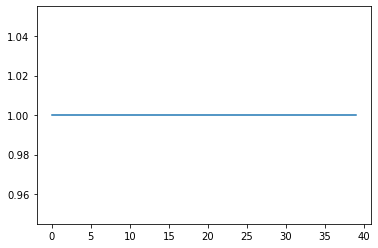

In [77]:
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(40)]);

In [78]:
fi = rf_feat_importance(model, df_trn); fi[:30]

,cols,imp
0,timestamp,0.0
1,name,0.0
2,uv,0.0
3,timestamp_year,0.0
4,timestamp_month,0.0
5,timestamp_week,0.0
6,timestamp_day,0.0
7,timestamp_hour,0.0
8,timestamp_minute,0.0
9,timestamp_dayofweek,0.0


### Exporting model & predictions to API

In [79]:
import pickle

In [83]:
os.makedirs('model', exist_ok=True)
!dir "model"
pickle.dump(model, open("./model", 'wb')) #writing in binary mode

 Volume in drive C is Windows
 Volume Serial Number is 984A-EC2B

 Directory of C:\Users\simon\OneDrive - PXL\School\2TINQ\_Research Project\OpenRemote-Energy-Challenge\machine-learning\model

16/06/2021  12:54    <DIR>          .
16/06/2021  12:54    <DIR>          ..
               0 File(s)              0 bytes
               2 Dir(s)  124.829.327.360 bytes free


PermissionError: [Errno 13] Permission denied: './model'

In [122]:
os.makedirs('predictions', exist_ok=True)

#predictions = pd.DataFrame(preds[:,0])
predictions = pd.DataFrame(df)
#predictions = predictions.rename(columns={0 : 'predicted_uv'})

PREDICTION_PATH='./predictions/predictions' + datetime.now().strftime("%Y%m%d%H%M%S") + '.csv'

predictions.to_csv(PREDICTION_PATH, index=False)
!dir "predictions"
predictions

 Volume in drive C is Windows
 Volume Serial Number is 984A-EC2B

 Directory of C:\Users\simon\OneDrive - PXL\School\2TINQ\_Research Project\OpenRemote-Energy-Challenge\machine-learning\predictions

16/06/2021  14:10    <DIR>          .
16/06/2021  14:10    <DIR>          ..
16/06/2021  13:57               514 predictions20210616135745.csv
16/06/2021  14:10               701 predictions20210616141055.csv
               2 File(s)          1.215 bytes
               2 Dir(s)  124.841.394.176 bytes free


,timestamp,name,uv,timestamp_year,timestamp_month,timestamp_week,timestamp_day,timestamp_hour,timestamp_minute,timestamp_dayofweek
0,1,2,0.0,2021,2,6,11,4,10,3
1,18,1,0.0,2021,2,8,25,5,13,3
2,17,2,0.0,2021,2,8,25,4,43,3
3,16,1,0.0,2021,2,8,25,4,43,3
4,15,2,0.0,2021,2,8,25,4,13,3
5,14,1,0.0,2021,2,8,25,4,13,3
6,13,2,0.0,2021,2,7,18,5,11,3
7,12,1,0.0,2021,2,7,18,4,41,3
8,11,2,0.0,2021,2,7,18,4,41,3
9,10,1,0.0,2021,2,7,18,4,11,3


In [126]:
OUR_API_URL = "http://51.75.73.83:9090/energy/pushData"

In [127]:
push_request = requests.post(OUR_API_URL, files={"predictions": PREDICTION_PATH})

In [128]:
push_request.text

'{"timestamp":"2021-06-16T12:39:47.746+00:00","status":405,"error":"Method Not Allowed","message":"","path":"/energy/pushData"}'